In [201]:
import warnings

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import make_scorer, precision_score, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, TargetEncoder

from lightgbm import LGBMRegressor

import holidays
import datetime as DT

warnings.filterwarnings('ignore')

random_state = 42

In [202]:
try:
    df = pd.read_csv('/Users/maiiayakusheva/Downloads/sp_sales_task/sales_df_train.csv')
except:
    df = pd.read_csv('/sales_df_train.csv')

In [203]:
df.date = pd.to_datetime(df.date)
df = df[((df.pr_sales_in_units!=0)&(df.pr_sales_in_rub!=0))|\
    ((df.pr_sales_in_units==0)&(df.pr_sales_in_rub==0))]
df = df[(df.pr_sales_in_units>=0) & (df.pr_promo_sales_in_units>=0) & (df.pr_sales_in_rub>=0)\
     & (df.pr_promo_sales_in_rub>=0)]

In [204]:
try:
    prod = pd.read_csv('/Users/maiiayakusheva/Downloads/sp_sales_task/pr_df.csv')
except:
    prod = pd.read_csv('/pr_df.csv')

In [205]:
try:
    station = pd.read_csv('/Users/maiiayakusheva/Downloads/sp_sales_task/st_df.csv')
except:
    station = pd.read_csv('/st_df.csv')

In [206]:
data = df.merge(prod, on='pr_sku_id').merge(station, on='st_id')

In [207]:
data = data[data.st_is_active==1]

In [208]:
data=data[(data.st_id!='bd470ca955d9497bbcb808e59952fffc')&(data.st_id!='53e19f3dbb211f20b20b45668303c1b6')]

In [209]:
holidays_list = []
for i in holidays.RUS(years=[2022, 2023]).items():
    holidays_list.append(str(i[0]))
holidays_list = holidays_list + ['2022-12-31', '2022-12-30', '2022-12-29', '2022-02-22', '2022-03-07',
 '2023-02-22', '2023-02-23', '2023-03-07']

In [210]:
big_sales = data[data.pr_sales_in_units>np.percentile(data.pr_sales_in_units, 95)]\
    [['date', 'pr_sales_in_units']]
big_sales['is_holiday'] = [1 if str(val).split()[0] in holidays_list else 0 for val in big_sales.date]
outliers_threshold = np.percentile(data.pr_sales_in_units, 95)

In [211]:
data.pr_uom_id = data.pr_uom_id.astype(str)
data.st_type_format_id = data.st_type_format_id.astype(str)
data.st_type_loc_id = data.st_type_loc_id.astype(str)
data.st_type_size_id = data.st_type_size_id.astype(str)

In [212]:
data.drop(['pr_sales_type_id', 'pr_promo_sales_in_units', 'pr_promo_sales_in_rub', 'st_is_active'],
 axis=1, inplace=True)

In [213]:
start_date = '2022-08-01'
end_date = '2023-07-18'
date_df = pd.DataFrame({'date':pd.date_range(start=start_date, end=end_date, freq='D')})
seq_df = data[['st_id', 'pr_sku_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'st_city_id',
    'st_division_code', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id']]\
        .drop_duplicates()
date_grid = date_df.merge(seq_df, how='cross')
date_grid.date = pd.to_datetime(date_grid.date)
temp_data = date_grid.merge(data[['st_id', 'pr_sku_id', 'date', 'pr_sales_in_units', 'pr_sales_in_rub']],
 on=['st_id', 'pr_sku_id', 'date'], how='left')

In [214]:
data = temp_data.groupby(['date', 'st_id', 'pr_sku_id', 'pr_group_id', 'pr_cat_id',
       'pr_subcat_id', 'pr_uom_id', 'st_city_id', 'st_division_code',
       'st_type_format_id', 'st_type_loc_id', 'st_type_size_id']).\
              agg(pr_sales_in_units=('pr_sales_in_units', 'sum'),
               pr_sales_in_rub=('pr_sales_in_rub', 'sum')).reset_index()

новое

In [215]:
data['is_promo'] = pd.Series(np.where((data.pr_sales_in_units>np.percentile(data.pr_sales_in_units, 95))\
     & (big_sales.is_holiday==0), 1, 0), index=data.index)
data.is_promo = data.is_promo.astype(str)

In [216]:
data = data.rename(columns={'pr_sales_in_units': 'target'})

In [217]:
data.drop('pr_sales_in_rub', axis=1, inplace=True)

In [218]:
sub = pd.read_csv('/Users/maiiayakusheva/Downloads/sp_sales_task/sales_submission.csv')
sub.date = pd.to_datetime(sub.date)
sub.index = sub.date
sub.sort_index(inplace=True)

In [219]:
sub = sub.merge(prod, on=['pr_sku_id'], how='left').merge(station, on=['st_id'], how='left')

In [220]:
sub['is_promo']=0

In [221]:
full = pd.concat([data, sub], axis=0).drop('st_is_active', axis=1)

In [222]:
full['is_holiday'] = [1 if str(val).split()[0] in holidays_list else 0 for val in full.date]
full.is_holiday = full.is_holiday.astype(str)

In [223]:
full['month'] = full.date.dt.month.astype(str)
full['day_of_week'] = full.date.dt.day_of_week.astype(str)
full['day_of_year'] = full.date.dt.day_of_year.astype(str)
full['day'] = full.date.dt.day.astype(str)
full['year_end'] = full.date.dt.is_year_end.astype(str)
full['year'] = full.date.dt.year.astype(str)

In [224]:
class_df = full.copy()
class_df['outliers'] = pd.Series(np.where(class_df.target>outliers_threshold, 1, 0))

In [225]:
sub.date

0       2023-07-19
1       2023-07-19
2       2023-07-19
3       2023-07-19
4       2023-07-19
           ...    
43689   2023-08-01
43690   2023-08-01
43691   2023-08-01
43692   2023-08-01
43693   2023-08-01
Name: date, Length: 43694, dtype: datetime64[ns]

In [226]:
train_class = class_df[class_df.date<='2023-07-18']
test_class = class_df[class_df.date>'2023-07-18']
X_train_class = train_class.drop(['outliers', 'is_promo', 'is_holiday', 'date'], axis=1)
y_train_class = train_class.outliers
X_test_class = test_class.drop(['outliers', 'is_promo', 'is_holiday', 'date'], axis=1)
y_test_class = test_class.outliers

In [227]:
cat_col = ['st_id', 'pr_sku_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id',
       'pr_uom_id', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'month', 'day_of_week', 'day_of_year',
       'day', 'year_end', 'year']
num_col = ['target']

In [228]:
enc = TargetEncoder(target_type='continuous', smooth='auto')
scaler = StandardScaler()

In [229]:
enc.fit(X_train_class[cat_col], y_train_class)
enc_cols = enc.get_feature_names_out(X_train_class[cat_col].columns)
X_train_class_enc = pd.DataFrame(enc.transform(X_train_class[cat_col]), columns=enc_cols,
 index=X_train_class[cat_col].index)
X_test_class_enc = pd.DataFrame(enc.transform(X_test_class[cat_col]), columns=enc_cols,
 index=X_test_class[cat_col].index)

In [230]:
scaler.fit(X_train_class[num_col])
colss = scaler.get_feature_names_out(X_train_class[num_col].columns)
X_train_class_scaled = pd.DataFrame(scaler.transform(X_train_class[num_col]), columns=colss,
 index=X_train_class[num_col].index)
X_test_class_scaled = pd.DataFrame(scaler.transform(X_test_class[num_col]), columns=colss,
 index=X_test_class[num_col].index)
X_train_class = pd.concat([X_train_class_enc, X_train_class_scaled], axis=1)
X_test_class = pd.concat([X_test_class_enc, X_test_class_scaled], axis=1)

In [231]:
scoring = make_scorer(precision_score, greater_is_better=True)
tscv = TimeSeriesSplit(n_splits=6)
logr = LogisticRegression()
parametrs = {}
logr_grid = GridSearchCV(logr, parametrs, scoring=scoring, cv=tscv)
logr_grid.fit(X_train_class, y_train_class)
all_class_preds = logr_grid.best_estimator_.predict_proba(X_train_class)
test_class_preds = logr_grid.best_estimator_.predict_proba(X_test_class)[:,1]
full['probs'] = pd.Series(all_class_preds[:,1])

In [232]:
y_test = full[full.date>'2023-07-18'].target
temp_test = full[full.date>'2023-07-18'].drop(['target', 'probs'], axis=1)
data = full[full.date<='2023-07-18']
temp_test['target']=0
temp_test['probs']=test_class_preds
data = pd.concat([data, temp_test], axis=0)
data = data.sort_values(by=['date', 'st_id', 'pr_sku_id'])

In [233]:
data.index = data.date
for n in range(14, 36, 7):
    data[f'lag{n}'] = data.target\
        .shift(data.date.value_counts().values[0]*n)
data.dropna(inplace=True)

In [234]:
#data = data[data.date>='2023-06-12']

In [235]:
#data.to_csv('/Users/maiiayakusheva/Desktop/data.csv')

In [236]:
train_data = data[data.date<='2023-07-18']
test_data = data[data.date>'2023-07-18']
X = train_data.drop('target' , axis=1)
y = train_data.target
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.2)

In [237]:
nums = ['lag14', 'lag21', 'lag28', 'lag35', 'probs']
cats = ['st_id', 'pr_sku_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'st_city_id',
    'st_division_code', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'is_holiday',
    'month', 'day_of_week', 'day_of_year', 'day', 'year_end', 'year']

In [238]:
enc.fit(X_train[cats], y_train)
new_columns = enc.get_feature_names_out(X_train[cats].columns)
X_train_enc = pd.DataFrame(enc.transform(X_train[cats]), columns=new_columns, index=X_train[cats].index)
X_val_enc = pd.DataFrame(enc.transform(X_val[cats]), columns=new_columns, index=X_val[cats].index)
scaler.fit(X_train[nums])
col = scaler.get_feature_names_out(X_train[nums].columns)
X_train_scaled = pd.DataFrame(scaler.transform(X_train[nums]), columns=col, index=X_train[nums].index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val[nums]), columns=col, index=X_val[nums].index)
X_train = pd.concat([X_train_enc, X_train_scaled], axis=1)
X_val = pd.concat([X_val_enc, X_val_scaled], axis=1)

In [239]:
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))
score = make_scorer(wape, greater_is_better=False)

In [240]:
lgbm = LGBMRegressor(random_state=random_state)
parametrs = {'learning_rate': [0.1, 0.01, 0.001, 0.0001]}
lgbm_grid = GridSearchCV(lgbm, parametrs, scoring=score, cv=tscv)
lgbm_grid.fit(X_train, y_train)
wape(y_val, lgbm_grid.best_estimator_.predict(X_val))

0.405667972177984

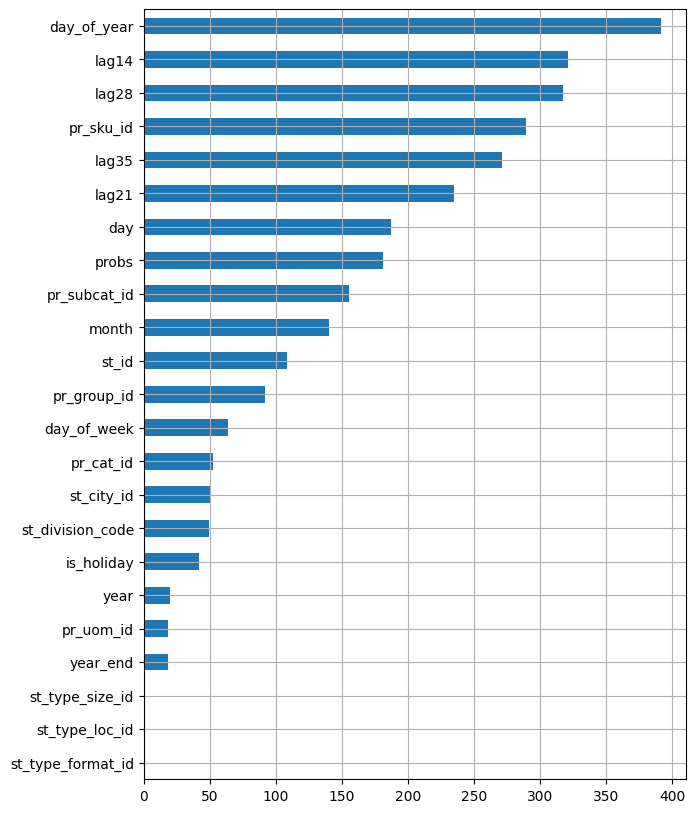

In [243]:
pd.DataFrame(data={'score': lgbm_grid.best_estimator_.feature_importances_}, 
                      index=X_train.columns).sort_values(by='score').plot(kind='barh', grid=True,
                                               figsize=(7,10), legend=False);

Модель:

In [33]:
#import pickle

In [34]:
#filename = 'finalized_model.sav'
#pickle.dump(lgbm_grid.best_estimator_, open(filename, 'wb'))

In [242]:
X_test = test_data.drop('target', axis=1)
X_test_enc = pd.DataFrame(enc.transform(X_test[cats]), columns=new_columns, index=X_test[cats].index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[nums]), columns=col, index=X_test[nums].index)
X_test = pd.concat([X_test_enc, X_test_scaled], axis=1)

In [244]:
#lgbm_grid.best_estimator_.predict(X_test).to_csv()